# 图神经网络-gcn


参考：

矩阵运算方式的详细介绍

https://blog.csdn.net/qq_43787862/article/details/113830925


很详细，频谱原理，有矩阵运算的细节

https://blog.csdn.net/yyl424525/article/details/100058264/


pyg的官方课程有ppt与代码下载

https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html


实践代码略繁琐，有gcn底层代码讲解

https://torture.blog.csdn.net/article/details/125287908


##  GCNConv的简单源码

In [ ]:
# GCNConv 简单的实现方式

class GCNConv_s(nn.Module):
    def __init__(self, input_dim, output_dim, use_bias=True):

        super(GCNConv_s, self).__init__()
        self.input_dim = input_dim  # 输入维度
        self.output_dim = output_dim  # 输出维度
        self.use_bias = use_bias  # 偏置
        self.weight = nn.Parameter(torch.Tensor(input_dim, output_dim))  # 初始权重
        if self.use_bias:
            self.bias = nn.Parameter(torch.Tensor(output_dim))  # 偏置
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # 重新设置参数
        # 进行凯明初始化
        nn.init.kaiming_uniform_(self.weight)
        if self.use_bias:
            # 偏置先全给0
            nn.init.zeros_(self.bias)

    def forward(self, adjacency, input_feature, l=1):
        '''

        :param adjacency: 邻接矩阵
        :param input_feature: 输入特征
        :param l: lambda 影响自环权重值
        :return:
        '''
        # 公式: (D^-0.5) A' (D^-0.5) X W
        size = adjacency.shape[0]
        # X W
        support = torch.mm(input_feature, self.weight)

        # A' = A + \lambda I
        A = adjacency+l*torch.eye(size)

        # D: degree
        SUM = A.sum(dim=1)
        D = torch.diag_embed(SUM)
        # D'=D^(-0.5)
        D = D.__pow__(-0.5)
        # 让inf值变成0
        D[D == float("inf")] = 0

        # (D^-0.5) A' (D^-0.5)
        adjacency = torch.sparse.mm(D, adjacency)
        adjacency = torch.sparse.mm(adjacency, D)

        # (D^-0.5) A' (D^-0.5) X W
        output = torch.sparse.mm(adjacency, support)

        if self.use_bias:
            # 使用偏置
            output += self.bias
        return output

    def __repr__(self):
        # 打印的时候内存信息属性
        return self.__class__.__name__ + ' (' + str(self.input_dim) + ' -> ' + str(self.output_dim) + ')'

## Cora数据集与点分类任务

Cora数据集，该数据集由 2708 篇论文，及它们之间的引用关系构成的 5429 条边组成。
这些论文被根据主题划分为7类，分别是神经网络、强化学习、规则学习、概率方法、遗传算法、理论研究、案例相关。
每篇论文的特征是通过词袋模型得到的，维度为1433，每一维表示一个词，1表示该词在这篇文章中出现过，0表示未出现。

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
from torch.nn import Linear

In [4]:
# 导入Cora数据集
dataset=Planetoid(root=r"./data",name="Cora") # root: 指定路径 name: 数据集名称
# 查看数据的基本情况
print("网络数据包含的类数量:",dataset.num_classes)
print("网络数据边的特征数量:",dataset.num_edge_features)
print("网络数据边的数量:",dataset.edge_index.shape[1]/2) # 除以2是OOC的组织形式
print("网络数据节点的特征数量:",dataset.num_node_features)
print("网络数据节点的数量:",dataset.x.shape[0])

网络数据包含的类数量: 7
网络数据边的特征数量: 0
网络数据边的数量: 5278.0
网络数据节点的特征数量: 1433
网络数据节点的数量: 2708


In [5]:
#dataset.edge_index
len(dataset.y)

2708

In [6]:
#dataset.data
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [7]:
dataset[0].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [8]:
# 通过networkx库进行可视化
CoraNet=to_networkx(dataset[0]) # type : networkx.classes.graph.Graph
CoraNet=CoraNet.to_undirected() # 转化为无向图

# 查看网络情况
print("网络的边的数量: ",CoraNet.number_of_edges())
print("网络的节点的数量: ",CoraNet.number_of_nodes())
Node_class=dataset.y.data.numpy()
print("节点分类:",Node_class)

网络的边的数量:  5278
网络的节点的数量:  2708
节点分类: [3 4 4 ... 3 3 3]


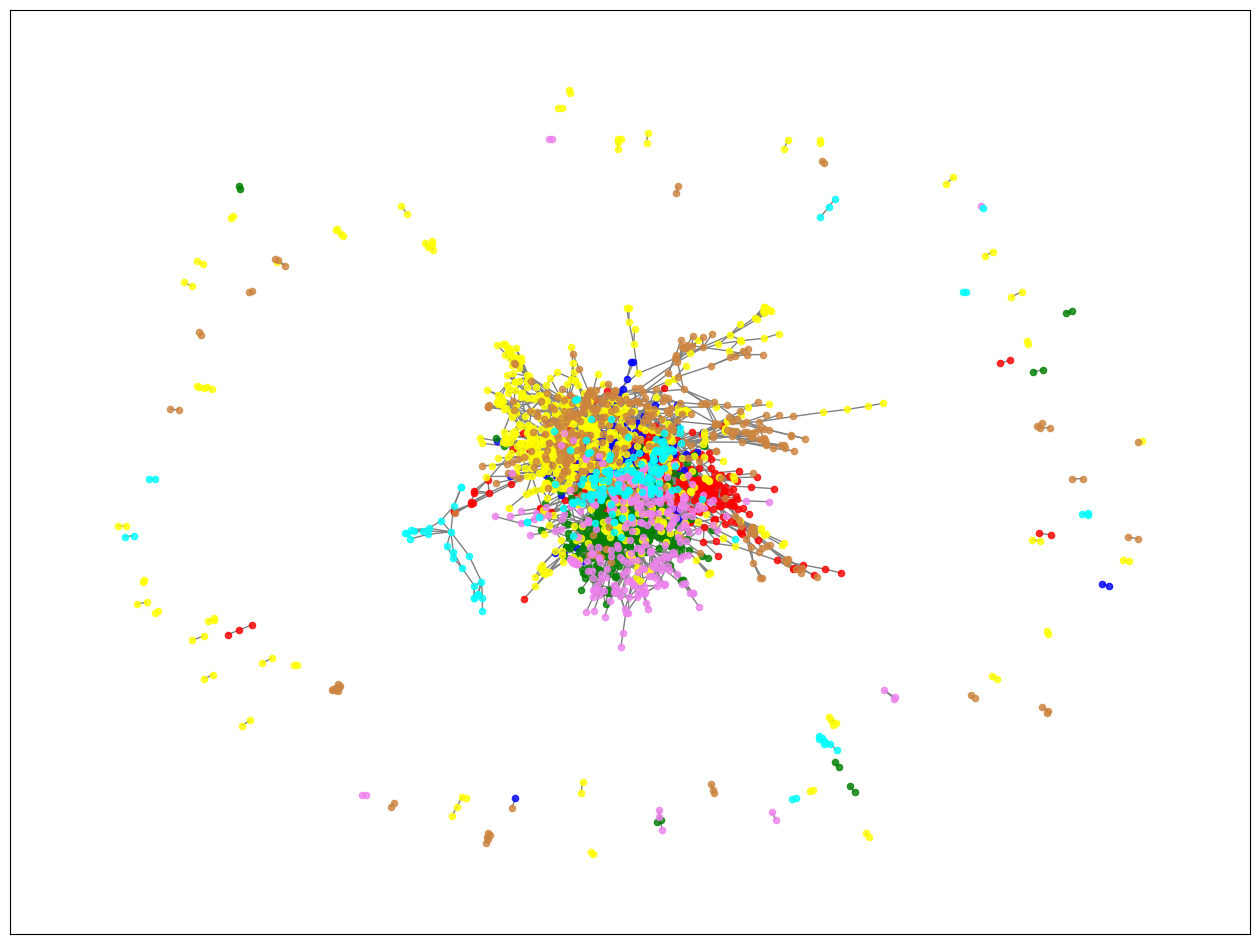

In [9]:
# nx图结构可视化
pos=nx.spring_layout(CoraNet) # 网络图中节点的布局方式
nodecolor=["red","blue","green","yellow","peru","violet","cyan"]
nodelabel=np.array(list(CoraNet.nodes))
plt.figure(figsize=(16,12))

# 不同的类使用不同的颜色
for ii in np.arange(len(np.unique(Node_class))):
    nodelist=nodelabel[Node_class==ii]
    # 绘制节点
    nx.draw_networkx_nodes(CoraNet,pos,nodelist=list(nodelist),node_size=20,
                           node_color=nodecolor[ii],alpha=0.8)

# 为网络添加边
nx.draw_networkx_edges(CoraNet,pos,width=1,edge_color="gray")
plt.show()

### 传统神经网络的实现

In [10]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

In [11]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
data=dataset[0]

for i in range(1000):
    out = model.forward(data.x)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.

    print("epoch:{} , loss:{}, accracy:{}".format(i,loss,test_acc))

epoch:0 , loss:1.9619522094726562, accracy:0.1
epoch:1 , loss:1.9027512073516846, accracy:0.108
epoch:2 , loss:1.8414477109909058, accracy:0.14
epoch:3 , loss:1.7561613321304321, accracy:0.166
epoch:4 , loss:1.6390374898910522, accracy:0.223
epoch:5 , loss:1.5613676309585571, accracy:0.256
epoch:6 , loss:1.4281829595565796, accracy:0.278
epoch:7 , loss:1.3505451679229736, accracy:0.308
epoch:8 , loss:1.2641708850860596, accracy:0.336
epoch:9 , loss:1.178624153137207, accracy:0.331
epoch:10 , loss:1.0886567831039429, accracy:0.315
epoch:11 , loss:0.9625499248504639, accracy:0.336
epoch:12 , loss:0.9238315224647522, accracy:0.355
epoch:13 , loss:0.8176745772361755, accracy:0.356
epoch:14 , loss:0.7710466980934143, accracy:0.366
epoch:15 , loss:0.6765591502189636, accracy:0.376
epoch:16 , loss:0.6483007073402405, accracy:0.376
epoch:17 , loss:0.5991811752319336, accracy:0.37
epoch:18 , loss:0.5321784019470215, accracy:0.36
epoch:19 , loss:0.5321124196052551, accracy:0.342
epoch:20 , loss:

### 图神经网络的实现

In [12]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

In [13]:
model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
opt = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.
data=dataset[0]

for i in range(1000):
    out = model.forward(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()

    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.

    print("epoch:{} , loss:{}, accracy:{}".format(i,loss,test_acc))

epoch:0 , loss:1.9512755870819092, accracy:0.095
epoch:1 , loss:1.8534587621688843, accracy:0.204
epoch:2 , loss:1.7390815019607544, accracy:0.243
epoch:3 , loss:1.6211824417114258, accracy:0.288
epoch:4 , loss:1.4616442918777466, accracy:0.347
epoch:5 , loss:1.333328127861023, accracy:0.431
epoch:6 , loss:1.209903359413147, accracy:0.518
epoch:7 , loss:1.1018539667129517, accracy:0.578
epoch:8 , loss:0.9800645112991333, accracy:0.59
epoch:9 , loss:0.8722946047782898, accracy:0.612
epoch:10 , loss:0.7703158259391785, accracy:0.654
epoch:11 , loss:0.6845785975456238, accracy:0.632
epoch:12 , loss:0.5754107236862183, accracy:0.648
epoch:13 , loss:0.5386150479316711, accracy:0.674
epoch:14 , loss:0.4516831040382385, accracy:0.697
epoch:15 , loss:0.4167480170726776, accracy:0.683
epoch:16 , loss:0.3837454319000244, accracy:0.701
epoch:17 , loss:0.32034096121788025, accracy:0.682
epoch:18 , loss:0.2962862253189087, accracy:0.714
epoch:19 , loss:0.23860332369804382, accracy:0.72
epoch:20 , l